# Analysis View Transformations using SimCLR Augmentations

The popular suite of data augmentations often used in instance-discrimination based self-supervised learning involves random cropping. The SimCLR authors state "The crop of random size (uniform from 0.08 to 1.0 in area) of the original size and a random aspect ratio (default: of 3/4 to 4/3) of the original aspect ratio is made." (Chen et al. 2020, Appendix A). 

This notebook delves into the question: **Does random cropping preserve semantics, i.e. are the semantic classes (think semantic segmentation) between views consistent?**

We experiment with COCO-Stuff (Caesar et al. 2018) to see the overlap between views

In [144]:
# Import torch
import torch
import torchvision
import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity
from torchvision import transforms
from torchvision.transforms import functional as F
import numpy as np
import random
import pycocotools
import collections
import shutil
import tarfile
import os, sys
from PIL import Image
import tqdm.notebook
import wget

In [138]:
# PASCAL Dataloader (from https://github.com/VainF/DeepLabV3Plus-Pytorch/blob/master/datasets/voc.py)
DATASET_YEAR_DICT = {
    '2012': {
        'url': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar',
        'filename': 'VOCtrainval_11-May-2012.tar',
        'md5': '6cd6e144f989b92b3379bac3b3de84fd',
        'base_dir': 'VOCdevkit/VOC2012'
    },
    '2011': {
        'url': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2011/VOCtrainval_25-May-2011.tar',
        'filename': 'VOCtrainval_25-May-2011.tar',
        'md5': '6c3384ef61512963050cb5d687e5bf1e',
        'base_dir': 'TrainVal/VOCdevkit/VOC2011'
    },
    '2010': {
        'url': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2010/VOCtrainval_03-May-2010.tar',
        'filename': 'VOCtrainval_03-May-2010.tar',
        'md5': 'da459979d0c395079b5c75ee67908abb',
        'base_dir': 'VOCdevkit/VOC2010'
    },
    '2009': {
        'url': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar',
        'filename': 'VOCtrainval_11-May-2009.tar',
        'md5': '59065e4b188729180974ef6572f6a212',
        'base_dir': 'VOCdevkit/VOC2009'
    },
    '2008': {
        'url': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2008/VOCtrainval_14-Jul-2008.tar',
        'filename': 'VOCtrainval_11-May-2012.tar',
        'md5': '2629fa636546599198acfcfbfcf1904a',
        'base_dir': 'VOCdevkit/VOC2008'
    },
    '2007': {
        'url': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar',
        'filename': 'VOCtrainval_06-Nov-2007.tar',
        'md5': 'c52e279531787c972589f7e41ab4ae64',
        'base_dir': 'VOCdevkit/VOC2007'
    }
}


def voc_cmap(N=256, normalized=False):
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7-j)
            g = g | (bitget(c, 1) << 7-j)
            b = b | (bitget(c, 2) << 7-j)
            c = c >> 3

        cmap[i] = np.array([r, g, b])

    cmap = cmap/255 if normalized else cmap
    return cmap

class VOCSegmentation(data.Dataset):
    """`Pascal VOC <http://host.robots.ox.ac.uk/pascal/VOC/>`_ Segmentation Dataset.
    Args:
        root (string): Root directory of the VOC Dataset.
        year (string, optional): The dataset year, supports years 2007 to 2012.
        image_set (string, optional): Select the image_set to use, ``train``, ``trainval`` or ``val``
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
    """
    cmap = voc_cmap()
    def __init__(self,
                 root,
                 year='2012',
                 image_set='train',
                 download=False,
                 transform=None):

        is_aug=False
        if year=='2012_aug':
            is_aug = True
            year = '2012'
        
        self.root = os.path.expanduser(root)
        self.year = year
        self.url = DATASET_YEAR_DICT[year]['url']
        self.filename = DATASET_YEAR_DICT[year]['filename']
        self.md5 = DATASET_YEAR_DICT[year]['md5']
        self.transform = transform
        
        self.image_set = image_set
        base_dir = DATASET_YEAR_DICT[year]['base_dir']
        voc_root = os.path.join(self.root, base_dir)
        image_dir = os.path.join(voc_root, 'JPEGImages')

        if download:
            download_extract(self.url, self.root, self.filename, self.md5)

        if not os.path.isdir(voc_root):
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')
        
        if is_aug and image_set=='train':
            mask_dir = os.path.join(voc_root, 'SegmentationClassAug')
            assert os.path.exists(mask_dir), "SegmentationClassAug not found, please refer to https://github.com/VainF/DeepLabV3Plus-Pytorch/blob/master/README.md and prepare it manually"
            split_f = os.path.join( self.root, 'train_aug.txt')#'./datasets/data/train_aug.txt'
        else:
            mask_dir = os.path.join(voc_root, 'SegmentationClass')
            splits_dir = os.path.join(voc_root, 'ImageSets/Segmentation')
            split_f = os.path.join(splits_dir, image_set.rstrip('\n') + '.txt')

        if not os.path.exists(split_f):
            raise ValueError(
                'Wrong image_set entered! Please use image_set="train" '
                'or image_set="trainval" or image_set="val"')

        with open(os.path.join(split_f), "r") as f:
            file_names = [x.strip() for x in f.readlines()]
        
        self.images = [os.path.join(image_dir, x + ".jpg") for x in file_names]
        self.masks = [os.path.join(mask_dir, x + ".png") for x in file_names]
        assert (len(self.images) == len(self.masks))

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is the image segmentation.
        """
        img = Image.open(self.images[index]).convert('RGB')
        target = Image.open(self.masks[index])
        if self.transform is not None:
            if isinstance(self.transform, list) and len(self.transform) == 2: #To handle multi-crop
                img1, target1 = self.transform[0](img, target)
                img2, target2 = self.transform[1](img, target)
                return img1, target1, img2, target2
                
            img, target = self.transform(img, target)

        return img, target


    def __len__(self):
        return len(self.images)

    @classmethod
    def decode_target(cls, mask):
        """decode semantic mask to RGB image"""
        return cls.cmap[mask]

def download_extract(url, root, filename, md5):
    download_url(url, root, filename, md5)
    with tarfile.open(os.path.join(root, filename), "r") as tar:
        tar.extractall(path=root)

In [139]:
pascal = VOCSegmentation("./datasets/", year='2012_aug', image_set="train")

<Figure size 432x288 with 0 Axes>

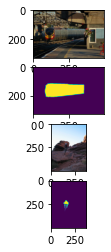

In [215]:
import matplotlib.pyplot as plt

img, mask = pascal.__getitem__(55)

img2, mask2 = pascal.__getitem__(5)

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, arr = plt.subplots(4,1) 
arr[0].imshow(img)
arr[1].imshow(mask)
arr[2].imshow(img2)
arr[3].imshow(mask2)
# plt.imshow(pascal.decode_target(mask2))


In [246]:
# From https://github.com/yassouali/pytorch-segmentation/blob/master/utils/lovasz_losses.py
def batch_intersection_union(mask1, mask2, num_class):
    intersection = mask1 * (mask1 == mask2).long()
    area_inter = torch.histc(intersection.float(), bins=num_class, max=num_class, min=1)
    area_pred = torch.histc(mask1.float(), bins=num_class, max=num_class, min=1)
    area_lab = torch.histc(mask2.float(), bins=num_class, max=num_class, min=1)
    area_union = area_pred + area_lab - area_inter
    assert (area_inter <= area_union).all(), "Intersection area should be smaller than Union area"
    return area_inter.cpu().numpy(), area_union.cpu().numpy()

def eval_metrics(mask1, mask2, num_class):
    mask1 = mask1 * ((mask1 > 0) * (mask1 <= num_class)).long()
    mask2 = mask2 * ((mask2 > 0) * (mask2 <= num_class)).long()
    inter, union = batch_intersection_union(mask1, mask2, num_class)
    return [np.round(inter, 5), np.round(union, 5)]

In [243]:
mask2_torch = torch.as_tensor(np.array(mask2), dtype=torch.int64).unsqueeze(0)
print(mask2_torch.shape)
inter, union = eval_metrics(mask2_torch, mask2_torch, 20)
print(inter)
print(inter / inter.sum())
print("--")
iou = 1.0 * inter / (np.spacing(1) + union)
print(iou, iou.mean())

# print(inter.sum() / (375*500))

torch.Size([1, 500, 375])
tensor([ 0,  2, 15]) tensor([184542,   1157,   1801])
[   0. 1157.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0. 1801.    0.    0.    0.    0.    0.]
[0.         0.39114267 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.60885733 0.         0.         0.
 0.         0.        ]
--
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 0.1


In [247]:
# Transforms
class MaskRandomResizedCrop():
    def __init__(self, size):
        super().__init__()
        self.size = size
        self.totensor = transforms.ToTensor()
        
    def __call__(self, image, mask):
        
        """
        Args:
            image (PIL Image or Tensor): Image to be cropped and resized.
            mask (PIL Image): Mask to be cropped and resized.
        Returns:
            Tensor: Randomly cropped/resized image.
            Mask Tensor: Randomly cropped/resized mask.
        """
        mask = torch.as_tensor(np.array(mask), dtype=torch.int64).unsqueeze(0) #Add channel dim

        i, j, h, w = transforms.RandomResizedCrop.get_params(image,scale=(0.08, 1.0), ratio=(3.0/4.0,4.0/3.0))
        image = transforms.functional.resize(transforms.functional.crop(image, i, j, h, w),(self.size,self.size),interpolation=transforms.functional.InterpolationMode.BICUBIC)
        
        # CHECK: RESIZE (??)
        image = torch.clip(self.totensor(image),min=0, max=255)
        mask = transforms.functional.resize(transforms.functional.crop(mask, i, j, h, w),(self.size,self.size),interpolation=transforms.functional.InterpolationMode.NEAREST)
        
        return [image,mask]

def get_iou(intersection, union):
    iou = 1.0 * intersection / (np.spacing(1) + union)
    return iou, iou.mean() 

def compute_overlap(root: str, dataset_name: str="voc", epochs: int=100, seed: int=0):
    # Set seed
    torch.manual_seed(seed)
    random.seed(seed)
    
    # Define Transforms
    simclr_transforms = [MaskRandomResizedCrop(224), MaskRandomResizedCrop(224)]
    if dataset_name == "voc": #Pascal use train_aug 2012
        dataset = VOCSegmentation(root, year="2012_aug", image_set="train", transform=simclr_transforms)
    else:
        raise NotImplementedError()
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, drop_last=False)

    inter, union = 0., 0.
    for epoch in tqdm.notebook.trange(epochs, desc='computing overlap', unit='epoch'):
        for (img1, mask1, img2, mask2) in dataloader:
            curr_inter, curr_union = eval_metrics(mask1, mask2, 20)
            inter += curr_inter
            union += curr_union
                
    return inter, union, len(dataset)


In [252]:
total_inter, total_union, total_samples = [0.]*3, [0.]*3, [0.]*3
epochs = 1
for seed in [0, 1, 2]:
    inter, union, samples = compute_overlap("./datasets/", "voc", epochs, seed)
    total_inter[seed] += inter
    total_union[seed] += union
    total_samples[seed] += samples

computing overlap:   0%|          | 0/1 [00:00<?, ?epoch/s]

computing overlap:   0%|          | 0/1 [00:00<?, ?epoch/s]

computing overlap:   0%|          | 0/1 [00:00<?, ?epoch/s]

TypeError: 'type' object is not subscriptable

In [255]:
iou, miou = 0., 0.
for seed in [0,1,2]:
    curr_iou, curr_miou = get_iou(total_inter[seed], total_union[seed])
    iou += curr_iou
    miou += curr_miou

print(iou / 3)
print(miou / 3)

[0.3600019  0.41209462 0.33366716 0.39492592 0.41370693 0.58266383
 0.530947   0.5467031  0.3083383  0.45189166 0.48213133 0.47536185
 0.38860163 0.48793817 0.4175427  0.48110893 0.449782   0.42454615
 0.48981094 0.43366858]
0.4432716369628906
